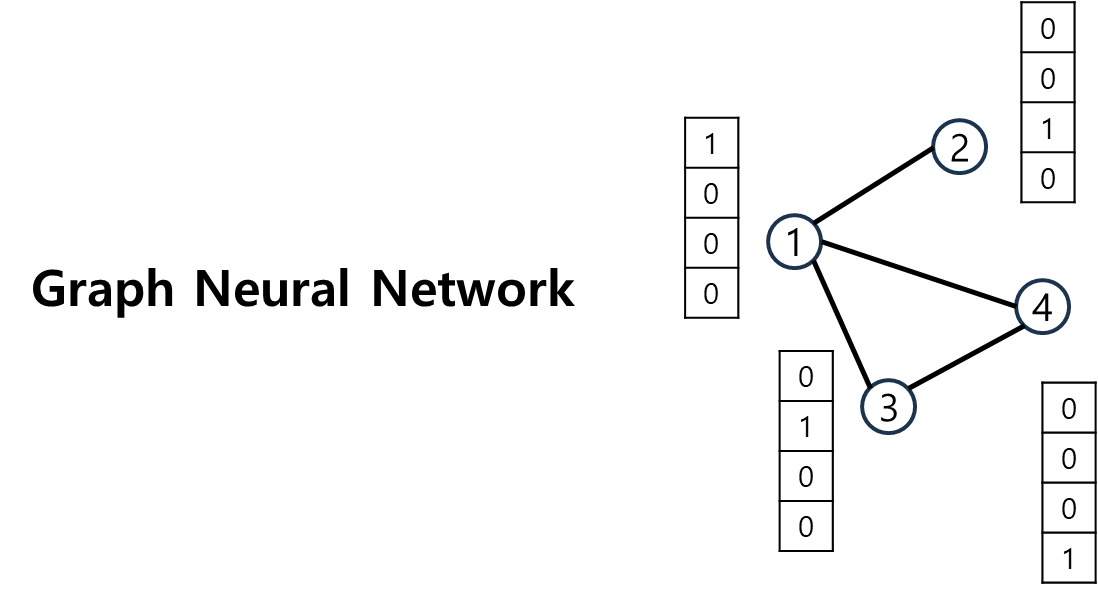

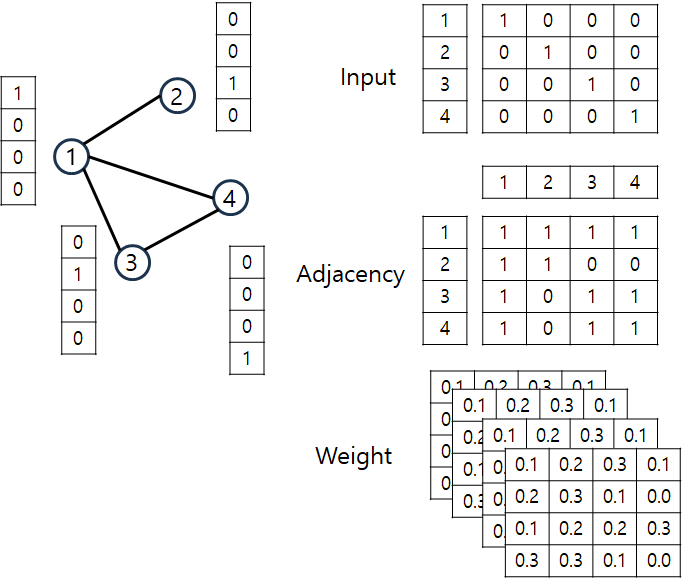

In [ ]:
!pip install torch torchvision torchaudio torch-geometric torch-sparse torch-scatter torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
!pip install pandas scikit-learn
!pip install networkx

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import networkx as nx  # Import the library
import matplotlib.pyplot as plt


# Example user-item interaction data in [user_code, item_code] format
user_item_pairs = [
    [0, 0],  # User 0 interacts with Item 0
    [0, 2],  # User 0 interacts with Item 2
    [1, 0],  # User 1 interacts with Item 1
    [1, 1],  # User 1 interacts with Item 1
    [2, 2],  # User 2 interacts with Item 2
    [2, 1],  # User 2 interacts with Item 1
    [3, 3],  # User 3 interacts with Item 3
    [3, 1]   # User 3 interacts with Item 1
]

user = ["tom", "james", "john", "jack"]
item = ["apple", "banana", "snack", "liquid"]

# Convert user-item pairs to edge_index format
# Shift item indices by the number of users to ensure unique node indices
num_users = 4
num_items = 4

edges = torch.tensor([
    [pair[0] for pair in user_item_pairs],  # User indices
    [pair[1] + num_users for pair in user_item_pairs]  # Item indices (shifted)
], dtype=torch.long)

# Features for users and items
user_features = torch.eye(num_users, dtype=torch.float)
item_features = torch.eye(num_items, dtype=torch.float)
node_features = torch.cat([user_features, item_features], dim=0)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edges)



In [ ]:

# Assuming 'data' is your Geometric Data object
# and it has attributes 'edge_index' and optionally 'edge_attr'

# Create a NetworkX graph
graph = nx.Graph()

# Add edges based on edge_index
for i in range(data.edge_index.shape[1]):
    source = data.edge_index[0, i].item()
    target = data.edge_index[1, i].item()
    graph.add_edge(source, target)

    # Add edge attributes if available and not None
    if hasattr(data, 'edge_attr') and data.edge_attr is not None:  # Check if edge_attr exists and is not None
        try:  # Try to access the edge attribute, handling potential IndexError
            edge_weight = data.edge_attr[i, 0].item()  # Assuming a single edge attribute
            graph[source][target]['weight'] = edge_weight
        except IndexError:
            print(f"Warning: No edge attribute found for edge {i}. Skipping...")



def get_node_label(node):
    if node < num_users:
        return user[node]
    else:
        return item[node - num_users]


# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(graph)  # You can choose a different layout if needed

# Draw nodes and edges
node_labels = {}
for node in graph.nodes:
    node_labels[node] = get_node_label(node)

nx.draw(graph, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue')

# Draw edge labels with weights (if available)
if hasattr(data, 'edge_attr') and data.edge_attr is not None:  # Check if edge_attr exists and is not None
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.title("Geometric Data Visualization")
plt.show()

In [ ]:
# Labels (optional, for supervised training; here we use dummy labels)
labels = torch.randint(0, 2, (num_users + num_items,), dtype=torch.long)


In [ ]:

# # Create labels based on user-item interaction patterns
# labels = torch.zeros(num_users + num_items, dtype=torch.long)

# # Example: Label users who interacted with item 1 as 1, others as 0
# # You can modify this logic to create more meaningful labels based on your specific needs.
# for i in range(len(user_item_pairs)):
#   user_index = user_item_pairs[i][0]
#   item_index = user_item_pairs[i][1]
#   if item_index == 1:  #Check if item index is 1
#       labels[user_index] = 1

# # # Example 2: Label items based on interactions
# # #  Item with more interactions gets higher label (or binary 1/0 based on interaction threshold)
# # interaction_counts = {}
# # for user_index, item_index in user_item_pairs:
# #     item_node = item_index + num_users
# #     interaction_counts[item_node] = interaction_counts.get(item_node, 0) + 1

# # for item_node, count in interaction_counts.items():
# #     labels[item_node] = 1 if count >= 2 else 0 # Example threshold

# labels

In [ ]:

# GCN Model definition
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.shape[1], hidden_channels=8, out_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

model

In [ ]:
data.x

In [ ]:
data.edge_index

In [ ]:

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")



In [ ]:
# prompt: 첫번째 GCN 의 가중치 테이블 출력
model.conv1.lin.weight

In [ ]:
# prompt: model의 중간 히든 벡터 8차원 데이터를 출력

# Get intermediate hidden layer representations
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    hidden_layer = model.conv1(data.x, data.edge_index)
    activated_hidden_layer = torch.relu(hidden_layer)

print("Hidden layer representations (8-dimensional):")
activated_hidden_layer

In [ ]:
model.conv2.lin.weight

In [ ]:
# Extract user embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

user_embeddings = embeddings[:num_users]  # First rows correspond to users
item_embeddings = embeddings[num_users:]  # Remaining rows correspond to items

print(user_embeddings)

print(item_embeddings)

In [ ]:
# Functions to find similar users and preferred items
def find_similar_users(user_id, user_embeddings, top_k=2):
    target_embedding = user_embeddings[user_id]
    similarities = torch.matmul(user_embeddings, target_embedding)
    _, indices = torch.topk(similarities, top_k + 1)  # +1 to exclude self
    return indices[indices != user_id]  # Exclude the user itself

def find_preferred_items(user_id, user_embeddings, item_embeddings, top_k=2):
    user_vector = user_embeddings[user_id]
    scores = torch.matmul(item_embeddings, user_vector)
    _, indices = torch.topk(scores, top_k)
    return indices

# Example: Find similar users and preferred items for User 0
similar_users = find_similar_users(1, user_embeddings)
preferred_items = find_preferred_items(0, user_embeddings, item_embeddings)

print("Target User : " + user[0])

for i in similar_users:
    print(f"Similar user to user2: {user[i]}")

for i in preferred_items:
    print(f"User1's preferred item: {item[i]}")
